<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel-FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import json
import zipfile
from io import BytesIO
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from IPython.display import Image, display_svg, SVG

import tensorflow as tf
import torch
import fastbook as fastai
fastai.setup_book()
from fastai import tabular
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
auth.authenticate_user()


     |████████████████████████████████| 719 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 12.5 MB/s 
     |████████████████████████████████| 4.4 MB 34.5 MB/s 
     |████████████████████████████████| 362 kB 51.6 MB/s 
     |████████████████████████████████| 212 kB 45.6 MB/s 
     |████████████████████████████████| 140 kB 36.9 MB/s 
     |████████████████████████████████| 1.1 MB 38.1 MB/s 
     |████████████████████████████████| 101 kB 9.5 MB/s 
     |████████████████████████████████| 596 kB 46.9 MB/s 
     |████████████████████████████████| 127 kB 47.4 MB/s 
     |████████████████████████████████| 271 kB 59.0 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 144 kB 45.9 MB/s 
     |████████████████████████████████| 6.6 MB 40.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.

In [123]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"

#events-20-min includes reports for all trains in the a 2 week window reporting at most every 20 minutes 
#filename = "train-events-20-min.zip"

#Train reportings 15 minutes apart - everything we have collected
filename = "train-data-master.zip"

# miles answers the question "what spped will this train be moving in X miles (technically at milepost +/-X)"
#measurement = { 'unit' : 'miles', 'size' : 1.0 }

# minutes answers the question : what speed will this train be moving in X Minutes
#measurement = { 'unit' : 'minutes', 'size' : 90.0 }

#dep_var = 'nextSpeed'

# milepost answers the question "What milepost will this train be at in X Minutes"
measurement = { 'unit' : 'milepost', 'size' : 60.0 }

dep_var = 'nextValue'

#Determines the portion of data to train versus validate
dataCutpoint = .80

In [124]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-master.zip...
| [1 files][236.7 MiB/236.7 MiB]                                                
Operation completed over 1 objects/236.7 MiB.                                    


In [125]:
trains = {}
i = 1
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      print(i, " ", datetime.now().strftime("%H:%M:%S"))
                            

1000   22:15:44
2000   22:15:50
3000   22:15:55
4000   22:16:09
5000   22:16:14
6000   22:16:20
7000   22:16:27
8000   22:16:40
9000   22:16:45
10000   22:16:51
11000   22:16:56
12000   22:17:01
13000   22:17:06
14000   22:17:20
15000   22:17:25
16000   22:17:30
17000   22:17:35
18000   22:17:40
19000   22:17:56
20000   22:18:01
21000   22:18:06
22000   22:18:11
23000   22:18:16
24000   22:18:21
25000   22:18:39
26000   22:18:44
27000   22:18:49
28000   22:18:54
29000   22:18:59
30000   22:19:06
31000   22:19:11
32000   22:19:29
33000   22:19:35
34000   22:19:40
35000   22:19:45
36000   22:19:50
37000   22:19:55
38000   22:20:00


In [126]:
dfTrainsAll = pd.concat(trains.values())

In [127]:
del trains

In [128]:
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

Filter out MP outside of Boone

In [129]:
dfTrainsAll = dfTrainsAll[dfTrainsAll['milepost'] < 327]
dfTrainsAll = dfTrainsAll[dfTrainsAll['milepost'] > 201]


In [130]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29770 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            29770 non-null  object 
 1   positionHistoryList                                            29770 non-null  object 
 2   locomotiveList                                                 29770 non-null  object 
 3   subdivisionList                                                29770 non-null  object 
 4   trainEstimatedPositionList                                     29770 non-null  object 
 5   trainActualPositionList                                        29770 non-null  object 
 6   trainId.trainSCAC                                              29728 non-null  object 
 7   trainId.trainSection                                          

# Create a learning set to modify

In [131]:
dfTrainsLearn = dfTrainsAll

Clear the nan values and replace with max values.

In [132]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)

Determine if the train is moving milepost Increasing or decreasing.

In [133]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

Make all speeds positive

In [134]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

Speed Distribution:


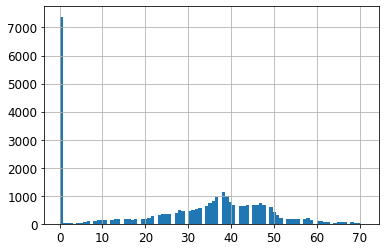

In [135]:
print("Speed Distribution:")
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

Replace the NaN values in AOTU with zeros

In [136]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

Categorize the applicable variables

In [137]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [138]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['M' 'U' 'E' 'G' 'C' 'A' 'I' 'W' 'Z' 'S' 'L' 'P']
['MT 1' 'MT 2' 'EASTXO' 'N SIDING' 'WESTXO' 'YD LD' '136' 'XO' '806' '405' '113']
['UP' 'UNK']
['' '2']
[4. 1. 3. 0.]
[12.  8. 15.  4.  2. 10. 19. 17. 11. 14.  0.]
[2. 1. 0.]
[2. 3. 0.]
['' 0.0]
[0.]


Replace unknown max speeds with 88 miles per hour (to make them recognizable)

In [139]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[60. 70. 50. 40. 88. 45. 79.  0. 30.]


Flatten out the work locations (we may want to change this for the NN algorithm)

In [140]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [141]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [142]:
dfTrainsLearn['workLocations'].unique()

array(['202.20', '258.40,202.20', None, '225.10', '202.20,258.40,321.50', '314.52,202.20', '321.50,202.20', '231.80,225.10', '214.50', '225.10,202.20', '202.20,258.40', '202.20,219.70',
       '219.70,202.20', '202.20,214.50,225.10,290.80,304.10', '202.20,258.40,225.10', '202.20,219.90,225.10', '202.20,257.60', '250.50,202.20', '268.40,202.20', '258.40,207.60,202.20',
       '207.60,202.20', '241.00,202.20', '258.40,219.70,202.20', '202.20,314.52', '202.92,202.20', '214.50,225.10,290.80,304.10,202.20', '290.80,258.40,231.80,202.20', '202.20,290.80',
       '202.20,299.75', '314.52,225.10,202.20', '202.20,219.70,277.50', '202.20,293.10', '202.20,304.10', '321.50,314.52,202.20', '202.20,240.90', '202.20,265.30', '265.30,202.20', '202.20,286.40',
       '240.90,207.60,202.20', '250.50,245.90,202.20', '219.70', '202.20,312.80', '321.50,240.90,202.20', '240.90,202.20', '202.20,207.60', '202.20,225.10', '326.20,214.50', '214.50,202.20',
       '240.90,214.50,202.20', '278.10,258.40,202.20', 

determine the locomotive count from the locomotive list.  We can make this more clever later, but for now this seems the most sensible shortcut

In [143]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

Convert the list of actual reportings into a dataframe.

In [144]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [145]:
def showTrain(idx):
  print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
  print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.subdivisionId'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.trackName'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])

You can peer into the incoming data here:

In [146]:
idx = 1
showTrain(idx)
dfTrainsLearnActuals.iloc[idx]

NS1007
MGBNP
106
MT 1
209.8707


,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-09T19:40:07Z,0,106,MT 1,209.87070
1,2022-06-09T19:42:07Z,0,106,MT 1,209.87070
2,2022-06-09T19:44:07Z,5,106,MT 1,210.15358
3,2022-06-09T19:46:07Z,11,106,MT 1,210.46217
4,2022-06-09T19:48:07Z,17,106,MT 1,210.88560
...,...,...,...,...,...
52,2022-06-09T21:26:07Z,35,106,MT 1,281.16560
53,2022-06-09T21:28:07Z,42,106,MT 1,282.40717
54,2022-06-09T21:30:07Z,49,106,MT 1,283.95746
55,2022-06-09T21:34:07Z,62,106,MT 1,287.82657


In [147]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,202.2072,"[{'positionTime': '2022-06-09T19:20:40Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 202.2072}}}, {'positionTime': '2022-06-09T19:22:40Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 203.70474}}}, {'positionTime': '2022-06-09T19:24:40Z', 'speedMPH': 49, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 205.29929}}}, {'positionTime': '2022-06-09T19:26:40Z', 'speedMPH': 53, 'milepostLocation': {'subdivisionId': 106..."
0,209.8707,[]
0,216.5130,"[{'positionTime': '2022-06-09T19:54:41Z', 'speedMPH': 26, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 216.513}}}, {'positionTime': '2022-06-09T19:56:41Z', 'speedMPH': 32, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 217.47511}}}, {'positionTime': '2022-06-09T19:58:41Z', 'speedMPH': 38, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 218.65654}}}, {'positionTime': '2022-06-09T20:00:41Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106,..."
0,224.2101,"[{'positionTime': '2022-06-09T20:11:30Z', 'speedMPH': 31, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 224.2101}}}, {'positionTime': '2022-06-09T20:13:30Z', 'speedMPH': 36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 225.32594}}}, {'positionTime': '2022-06-09T20:15:30Z', 'speedMPH': 41, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 226.61711}}}, {'positionTime': '2022-06-09T20:17:30Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106..."
0,235.8908,"[{'positionTime': '2022-06-09T20:27:41Z', 'speedMPH': 36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 235.8908}}}, {'positionTime': '2022-06-09T20:29:41Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 237.54869}}}, {'positionTime': '2022-06-09T20:31:41Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 238.9238}}}, {'positionTime': '2022-06-09T20:33:41Z', 'speedMPH': 44, 'milepostLocation': {'subdivisionId': 106,..."
...,...,...
0,217.0825,[]
0,215.1352,"[{'positionTime': '2022-06-04T01:18:01Z', 'speedMPH': -16, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 215.1352}}}, {'positionTime': '2022-06-04T01:20:01Z', 'speedMPH': -20, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 214.52847}}}, {'positionTime': '2022-06-04T01:22:01Z', 'speedMPH': -25, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 210.82147}}}, {'positionTime': '2022-06-04T01:24:01Z', 'speedMPH': -28, 'milepostLocation': {'subdivisionId':..."
0,207.0881,[]
0,207.0909,[]


Renumber the list

In [148]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

# Determine NextValue
This will be the value we are attempting to learn

In [149]:
def findNextTime(trainsEntry, actualsEntry, timeInMinutes):
  #print(actualsEntry.iloc[4]['speedMPH'], " - ",trainsEntry['lastReportedPosition.speedMPH'] )
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return (abs(actualsEntry.iloc[idx]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
  return None

In [150]:
def findNextMilepost(trainsEntry, actualsEntry, distance):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost + distance]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost - distance]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [151]:
def findNextMilepostAtTime(trainsEntry, actualsEntry, timeInMinutes):
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return actualsEntry.iloc[idx]['milepostLocation.milepost.milepostNumber']
  return None

In [152]:
def findNextSpeed(trainsEntry, actualsEntry):
  if (measurement.get('unit') == 'miles'):
    nextActual = findNextMilepost(trainsEntry, actualsEntry, measurement.get('size'))
    if (nextActual != None and len(nextActual) > 0):
      amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
      return amt;
  elif (measurement.get('unit') == 'minutes'):
    return findNextTime(trainsEntry, actualsEntry, measurement.get('size'))
  elif (measurement.get('unit') == 'milepost'):
    return findNextMilepostAtTime(trainsEntry, actualsEntry, measurement.get('size'))
  else:
    raise Exception('unknown measurement', measurement.get('unit'))    
  return None

You can peer into the mechanics of a lookup here:

In [153]:
idx = 3291
showTrain(idx)
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 1)
print("Next Speed at MP:",nextActual)
nextActual = findNextTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Next Speed at 10 Min:",nextActual)
nextActual = findNextMilepostAtTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Milepost in 10 Min:",nextActual)

print("actual Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx]))
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT, 1)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], beopDT))

UP2706
MCHCB
106
MT 2
320.4698
Reported speed:  39
Reported MP:  320.4698
Reported Time:  2022-05-11T10:25:35Z
Next Speed at MP:            positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-05-11T10:27:35Z        38                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                       MT 2                                 321.73276  
Next Speed at 10 Min: -39
Milepost in 10 Min: 325.6992
actual Value:  325.699
           positionTime  speedMPH  milepostLocation.subdivisionId  \
1  2022-05-11T10:27:35Z        40                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
1                       MT 2                                 321.80084  
beop Value:  369.28494


Run the calulations.  This will take a moment.

In [154]:
dfTrainsLearn['nextValue'] = np.NaN
dfTrainsLearn['beopValue'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextValue = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextValue != None):
    dfTrainsLearn.at[i,'nextValue'] = nextValue
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      if (measurement.get('unit') == 'miles'):
        nextBeop = findNextMilepost(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'minutes'):
        nextBeop = findNextTime(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'milepost'):
        nextBeop = findNextMilepostAtTime(trainsEntry, beopDT, measurement.get('size'))
      if (nextBeop != None):
        dfTrainsLearn.at[i,'beopValue'] = nextBeop
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [155]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextValue'])
dfTrainsLearn['nextValue'].unique()

array([232.89471, 243.68625, 257.6546 , ..., 217.01894, 207.47801, 205.17145])

NextValue values histogram:


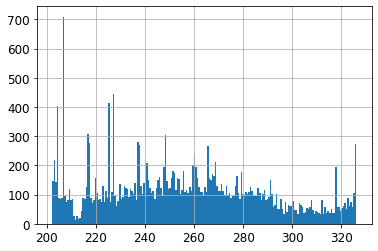

In [156]:
print("NextValue values histogram:")
dfTrainsLearn['nextValue'].hist(bins=200)

In [157]:
dfTrainsLearn['beopValue'].unique()

array([260.1106 ,       nan, 269.0104 , ..., 186.3567 , 176.57133, 174.76186])

physics predictions histogram:


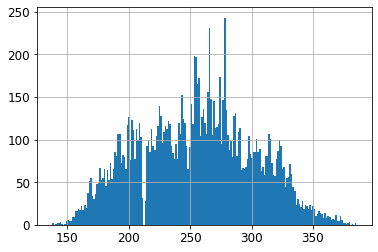

In [158]:
print("physics predictions histogram:")
dfTrainsLearn['beopValue'].hist(bins=200)

In [159]:
dfTrainsNextBeop = dfTrainsLearn['beopValue']

Drop some values we are not using at the moment, not needed.

Note, this will disable above computations unless you resume at "Create a learning set"

In [160]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'beopValue',
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

Burst dates into subcolumns that might prove useful

In [161]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,NS1007,UP,,MGBNP,...,False,False,False,1.654802e+09
1,NS1007,UP,,MGBNP,...,False,False,False,1.654803e+09
2,NS1007,UP,,MGBNP,...,False,False,False,1.654804e+09
3,NS1007,UP,,MGBNP,...,False,False,False,1.654805e+09
4,NS1007,UP,,MGBNP,...,False,False,False,1.654806e+09
...,...,...,...,...,...,...,...,...,...
29762,UP7942,UP,,MNPCH,...,False,False,False,1.654301e+09
29763,UP7942,UP,,MNPCH,...,False,False,False,1.654302e+09
29764,UP7942,UP,,MNPCH,...,False,False,False,1.654303e+09
29765,UP7942,UP,,MNPCH,...,False,False,False,1.654304e+09


In [162]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[10])

(22510, 47)
(29770,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22510 entries, 0 to 29766
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            22510 non-null  object        
 1   trainId.trainSCAC                                              22510 non-null  category      
 2   trainId.trainSection                                           22510 non-null  category      
 3   trainId.trainSymbol                                            22510 non-null  object        
 4   trainId.trainDate                                              22510 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  22510 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            22510 non-

# Use Decision Tree to predict next value

In [163]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

Breakdown the data by day of year - we will train with older data and then test the model with newer values.
Note: this simple logic will fail at the begining of a new year!

In [164]:
dateValues = dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count()
print(dateValues)

lastReportedPosition.positionTimeDayofyear
90      50
91     177
92     187
93     176
94      94
      ... 
183    288
184    211
185    211
186    214
187    360
Name: lastReportedPosition.positionTimeDayofyear, Length: 97, dtype: int64


In [165]:
print("We will partition this set at day of year:", dateValues.index[math.trunc(dateValues.size * dataCutpoint)])

We will partition this set at day of year: 167


In [166]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] <= dateValues.index[math.trunc(dateValues.size * dataCutpoint)] )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [167]:
#dep_var = 'nextSpeed'

In [168]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [169]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [170]:
len(to.train),len(to.valid)

(18149, 4361)

In [171]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextValue
0,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,42,202.207199,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,60.0,102.0,0.0,9738.0,7158.0,202,2,6,23,9,3,160,1.654802e+09,232.894714
1,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,0,209.870697,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,209,2,6,23,9,3,160,1.654803e+09,243.686249
2,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,26,216.513000,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,216,2,6,23,9,3,160,1.654804e+09,257.654602
3,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,31,224.210098,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,224,2,6,23,9,3,160,1.654806e+09,269.569092
4,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,36,235.890793,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,235,2,6,23,9,3,160,1.654806e+09,283.609772
5,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,62,246.540100,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,246,2,6,23,9,3,160,1.654807e+09,302.337982
6,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,50,260.289795,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,260,2,6,23,9,3,160,1.654808e+09,317.759552
31,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,33,202.206802,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0.0,0.0,70.0,106.0,0.0,10261.0,7619.0,202,4,6,22,4,5,155,1.654303e+09,243.997238
32,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,54,220.706604,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0.0,0.0,70.0,106.0,0.0,10261.0,7619.0,220,4,6,22,4,5,155,1.654304e+09,260.171692
33,NS4141,UP,,MGBNP,2022-06-02,106,MT 2,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,39,231.671707,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0

In [172]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating a Decision Tree

In [173]:
to = fastai.load_pickle('/tmp/to.pkl')

In [174]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [175]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

Here is a sample of a Decision Tree with just 16 nodes:

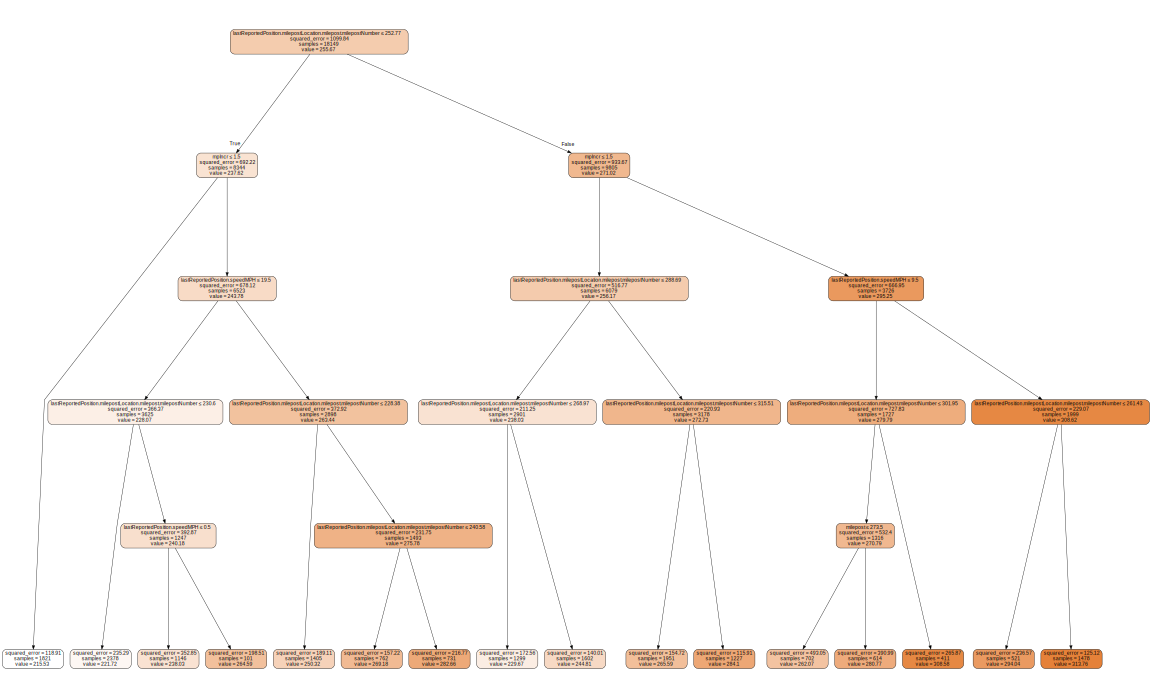

In [176]:
fastai.draw_tree(m, xs, size=16, leaves_parallel=True, precision=2)

In [177]:
m = DecisionTreeRegressor(min_samples_leaf=9)
m.fit(xs, y);

Root Mean Standard Error (RMSE)

In [178]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

How well we fit the training model:

In [179]:
trainingPreds = m.predict(xs)
r_mse(trainingPreds, y)

8.098305

How well we fit the Validation Model:

In [180]:
validationPreds = m.predict(valid_xs)
r_mse(validationPreds, valid_y)

13.601206

In [225]:
def showPredictions(predictionsSeries, validSeries):
  b = predictionsSeries.reset_index(drop=true)
  y = validSeries.reset_index(drop=true)
  df  = pd.concat([b, y], axis=1)
  df = df.dropna()
  df = df.rename(columns={ df.columns[0]: "prediction", df.columns[1]: "actual" })
  print(df)
  print("RMSE: ", r_mse(df.iloc[:,0], df.iloc[:,1]))

Simple Decision Tree Predictions:

In [226]:
showPredictions(pd.DataFrame(validationPreds), valid_y)

      prediction      actual
0     283.162222  291.374603
1     272.500277  290.969177
2     261.863200  282.523590
3     257.050539  275.740753
4     243.919424  245.180847
...          ...         ...
4356  243.335450  236.349045
4357  225.554347  225.254959
4358  214.193428  219.881546
4359  227.769530  217.072906
4360  213.186464  206.479767

[4361 rows x 2 columns]
RMSE:  13.601206


In [227]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [228]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
45,lastReportedPosition.positionTimeElapsed,0.459557
44,lastReportedPosition.positionTimeDayofyear,0.427686
4,trainId.trainDate,0.064607
41,lastReportedPosition.positionTimeWeek,0.048150
34,loadedCarCount,0.000000
26,aotuTrainData.totalLocomotiveWeight,0.000000
27,aotuTrainData.totalLocomotiveLength,0.000000
28,aotuTrainData.actualTonsPerAxle,0.000000
29,aotuTrainData.heavy143TonCarCount,0.000000
30,aotuTrainData.heavy158TonCarCount,0.000000


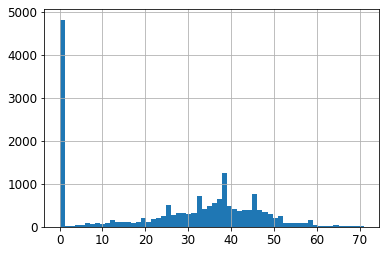

In [229]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/inspection/_plot/partial_dependence.py:1110: UserWarning: Attempting to set identical bottom == top == 0.19359999999999997 results in singular transformations; automatically expanding.
  ax.set_ylim(self.pdp_lim[1])


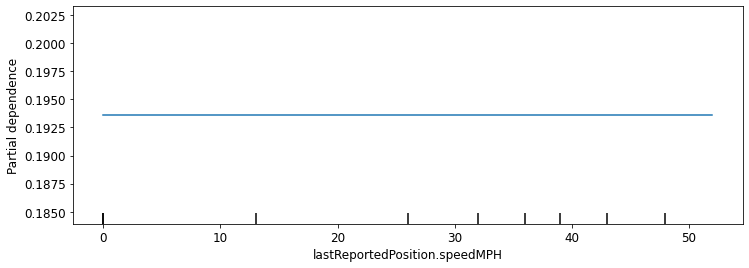

In [230]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

#Random Forest

In [231]:
def randomForest(xs, y, n_estimators=50, max_samples=10000,
       max_features=0.7, min_samples_leaf=7, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [232]:
m = randomForest(xs, y);

In [233]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(8.545614, 10.881913)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

Random Forest Predictions:

In [235]:
showPredictions(pd.DataFrame(preds.mean(0)), valid_y)


      prediction      actual
0     286.629459  291.374603
1     273.980198  290.969177
2     270.158058  282.523590
3     257.451388  275.740753
4     242.265221  245.180847
...          ...         ...
4356  237.300499  236.349045
4357  224.335729  225.254959
4358  223.627499  219.881546
4359  218.862162  217.072906
4360  213.562014  206.479767

[4361 rows x 2 columns]
RMSE:  10.881913


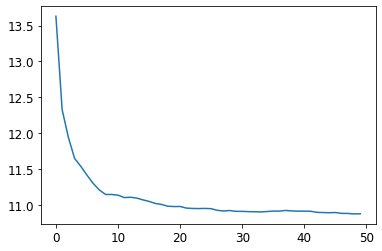

In [236]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

#Further Technical Inspections
Some checks for out-of-bag errors, etc.

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [237]:
r_mse(m.oob_prediction_, y)

10.38697

In [238]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [239]:
preds.shape

(50, 4361)

We can get the standard deviation of the predictions over all the trees, for each train:

In [240]:
preds_std = preds.std(0)

Standard Deviation for the predictions of the first 5 trains:


In [241]:
preds_std[:5]

array([5.82821423, 3.87719934, 6.75101472, 5.36201092, 7.01286148])

# FEATURE Importance

In [242]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.389660
12,mpIncr,0.251470
22,lastReportedPosition.speedMPH,0.144631
38,milepost,0.121721
3,trainId.trainSymbol,0.018160
14,workLocations,0.010104
6,lastReportedPosition.milepostLocation.trackName,0.005118
24,aotuTrainData.totalCarWeight,0.004208
35,emptyCarCount,0.004146
0,ptcLeadLocomotiveId,0.004137


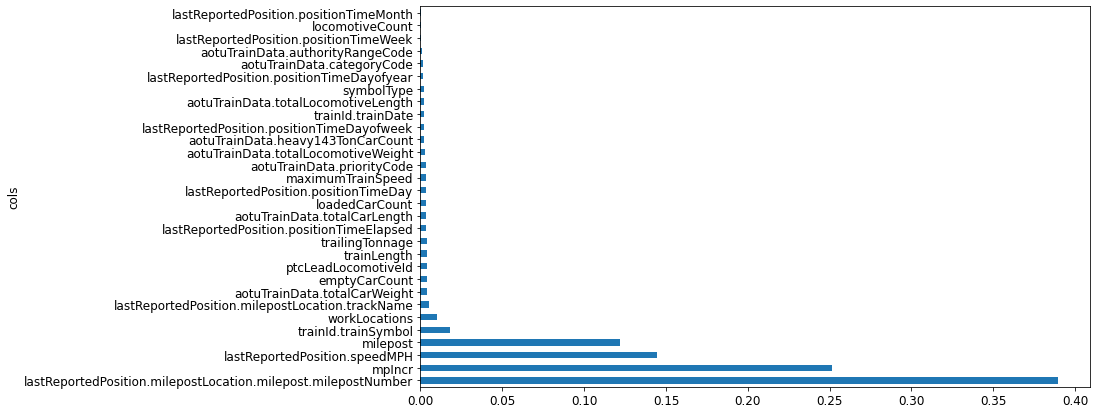

In [243]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [244]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

29

In [245]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [246]:
m = randomForest(xs_imp, y)

In [247]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(8.567356, 10.890329)

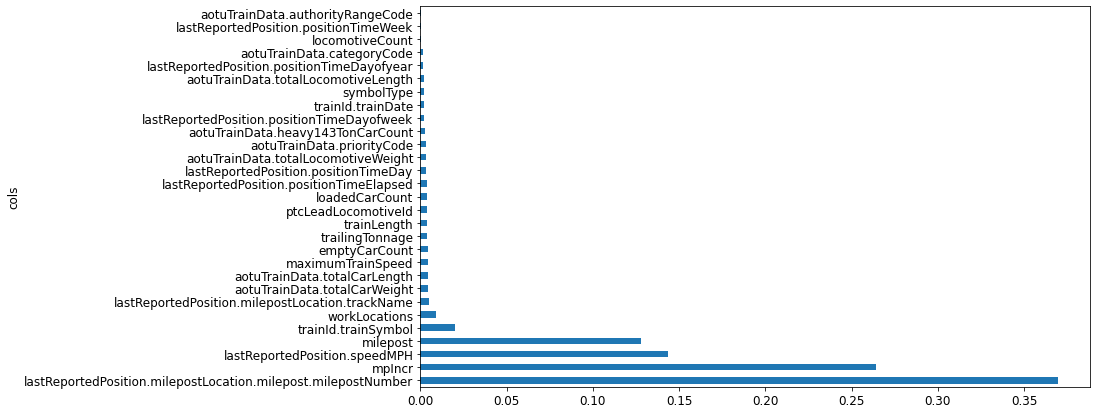

In [248]:
plot_fi(rf_feat_importance(m, xs_imp));

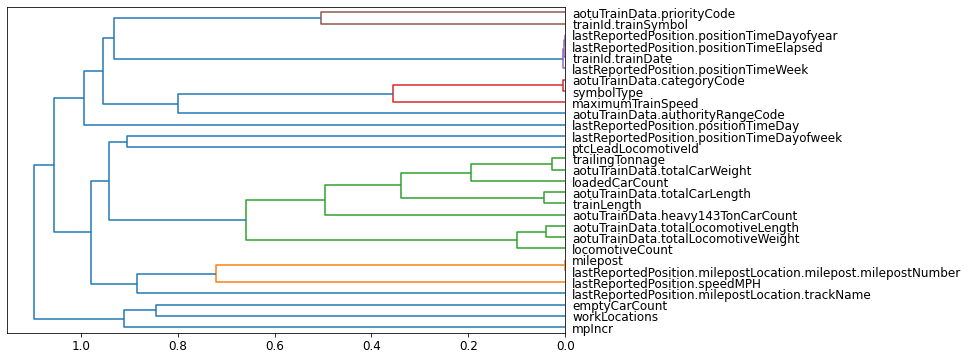

In [249]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [250]:
showPredictions(dfTrainsNextBeop.tail(len(valid_y)), valid_y)

      prediction      actual
6      268.34520  271.863678
7      255.98856  288.108734
8      246.14096  297.288300
9      240.29688  310.235687
12     236.80238  325.610992
...          ...         ...
4355   197.55089  243.677460
4356   195.44986  236.349045
4357   186.35670  225.254959
4358   176.57133  219.881546
4360   174.76186  206.479767

[2501 rows x 2 columns]
RMSE:  57.307469


# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [251]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.522508
45,lastReportedPosition.positionTimeElapsed,0.419745
41,lastReportedPosition.positionTimeWeek,0.034158
4,trainId.trainDate,0.015917
40,lastReportedPosition.positionTimeMonth,0.007673
33,maximumTrainSpeed,0.000000
26,aotuTrainData.totalLocomotiveWeight,0.000000
27,aotuTrainData.totalLocomotiveLength,0.000000


Consider whether these values make sense

#Using a Neural Net

In [252]:
df_nn_final = dfTrainsLearn

In [253]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22510 entries, 0 to 29766
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            22510 non-null  object        
 1   trainId.trainSCAC                                              22510 non-null  category      
 2   trainId.trainSection                                           22510 non-null  category      
 3   trainId.trainSymbol                                            22510 non-null  object        
 4   trainId.trainDate                                              22510 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  22510 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            22510 non-null  int64         


In [254]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [255]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [256]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    1001
trainId.trainSCAC                                         2
trainId.trainSection                                      2
trainId.trainSymbol                                     311
trainId.trainDate                                       102
lastReportedPosition.speedMPH                            72
lastReportedPosition.milepostLocation.subdivisionId       1
lastReportedPosition.milepostLocation.trackName          11
aotuTrainData.priorityCode                                4
aotuTrainData.categoryCode                               11
aotuTrainData.authorityRangeCode                          3
aotuTrainData.ownershipCode                               3
aotuTrainData.eventCode                                   1
milepost                                                123
mpIncr                                                    2
symbolType                                               12
workLocations                           

In [257]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [258]:
dls = to_nn.dataloaders(1024)

In [259]:
y = to_nn.train.y
y.min(),y.max()

(202.23622, 326.0935)

In [264]:
linearLayers=500
activations=250
learn = tabular_learner(dls, y_range=(202,327), layers=[linearLayers,activations],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0003981071640737355)

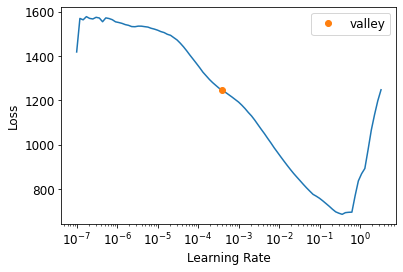

In [265]:
learn.lr_find()

In [262]:
# Default NN 
# learn.fit_one_cycle(50, 1e-4)

In [266]:
#"Ranger" Optimizer Uses Pytorch’s CosineAnnealing
learn.fit_flat_cos(20, 1e-4)

epoch,train_loss,valid_loss,time
0,884.981445,1168.147705,00:01
1,748.013855,1051.815308,00:01
2,644.455688,809.623718,00:01
3,542.614807,564.769043,00:01
4,450.379242,449.568390,00:01
5,369.354706,388.437103,00:01
6,307.199524,358.089844,00:01
7,259.646454,316.400330,00:01
8,222.393768,319.261108,00:01
9,193.258636,334.502258,00:01


In [223]:
# Stochastic Gradient Descent
# Too Much Ram -  cannot run here 
# learn.fit_sgdr(31, 10)

NN Predictions:

In [267]:
preds,targs = learn.get_preds()
showPredictions(pd.DataFrame(preds.numpy(), columns=['prediction']), 
                pd.DataFrame(targs.numpy(), columns=['actual']))

      prediction      actual
0     289.965057  291.374603
1     283.635254  290.969177
2     274.987549  282.523590
3     268.119995  275.740753
4     228.296844  245.180847
...          ...         ...
4356  247.979736  236.349045
4357  237.233704  225.254959
4358  231.349258  219.881546
4359  232.310196  217.072906
4360  226.810059  206.479767

[4361 rows x 2 columns]
RMSE:  17.232016
